**Deep Fake Recognition using Deep Learning Techniques**


In [ ]:
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] ='/content/gdrive/MyDrive/archive/Dataset/Test'

In [ ]:
%cd /content/drive/MyDrive/archive/Dataset

/content/drive/MyDrive/archive/Dataset


In [ ]:
#|!unzip \*.zip && rm *.zip

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = "/content/drive/MyDrive/archive/train/fake/76BCVZIK6E.jpg"
image = cv2.imread(img)


**Vision Transformer Based Model**

In [ ]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
!pip install -U tensorflow-addons
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
import random
%matplotlib inline
import cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 22.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
image_size = 224
labels = ('real', 'fake')
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]
                resized_arr = cv2.resize(img_arr, (image_size, image_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)

    return np.array(data, dtype='object')

In [ ]:
import os
os.chdir(r"/content/drive/MyDrive/archive/Dataset")
!ls

Test  Train


In [ ]:
train = get_data("/content/drive/MyDrive/archive/Dataset/Train")
test = get_data("/content/drive/MyDrive/archive/Dataset/Test")
print(train.shape)
print(test.shape)

(5651, 2)
(235, 2)


In [ ]:
l = []
for i in train:
    if i[1] == 0:
        l.append('real')
    else:
        l.append('fake')

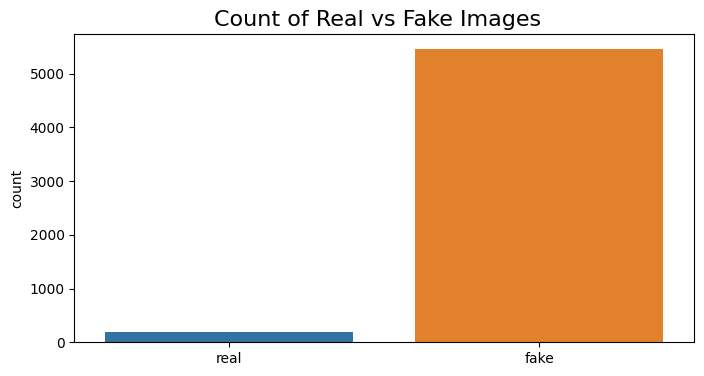

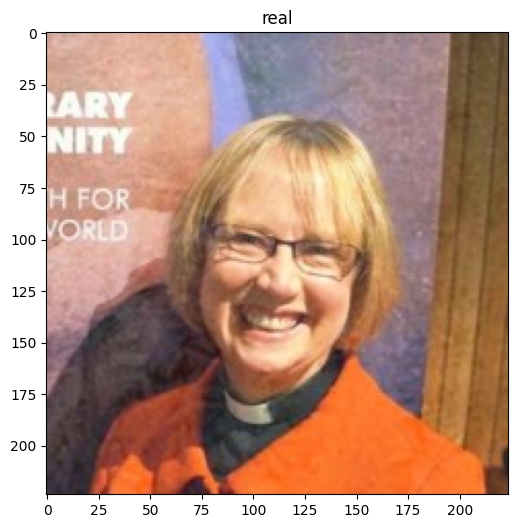

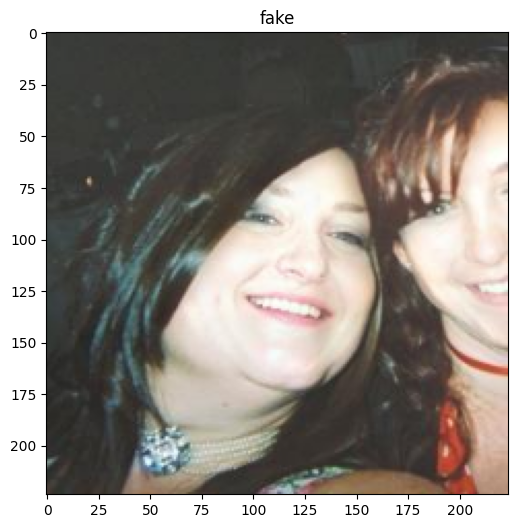

(5651, 224, 224, 3)
(235, 224, 224, 3)
(5651,)
(235,)


In [ ]:
plt.figure(figsize=(8, 4))
plt.title('Count of Real vs Fake Images  ', size=16)
sns.countplot(x=l)
plt.show()

# randomly visualizing images to see whats going on
plt.figure(figsize=(8, 6))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])
plt.show()

X_train = []
X_test = []
y_train = []
y_test = []

# dividing data into train and test sets
for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

# Normalise the image data (to convert it to range from 0 to 1)
X_train = np.array(X_train)# / 255.0

X_test = np.array(X_test) #/ 255.0

# # Reshaping the image data so that every image is the same size
# #X_train.reshape(-1, image_size, image_size, 1)
y_train = np.array(y_train)

# #X_test.reshape(-1, image_size, image_size, 1)

y_test = np.array(y_test)


y_test = np.array(y_test)
print (X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
num_classes = 2
input_shape = (224, 224, 3)

Vision Transformer Hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(X_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Patch Visualisation

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


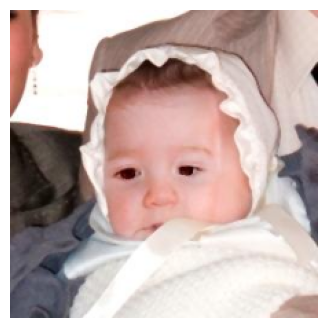

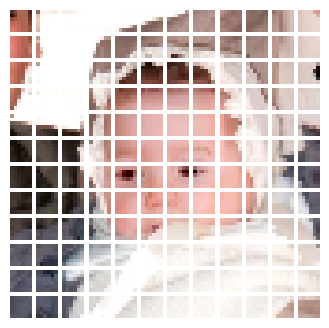

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

Patch Encoder class

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Creating VIT Model

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Running the VIT Model

Epoch 1/10
20/20 [==============================] - 447s 21s/step - loss: 1.1799 - accuracy: 0.9231 - top-5-accuracy: 1.0000 - val_loss: 0.4160 - val_accuracy: 0.7862 - val_top-5-accuracy: 1.0000
Epoch 2/10
20/20 [==============================] - 413s 21s/step - loss: 0.2204 - accuracy: 0.9546 - top-5-accuracy: 1.0000 - val_loss: 0.2520 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 421s 21s/step - loss: 0.1933 - accuracy: 0.9599 - top-5-accuracy: 1.0000 - val_loss: 0.1190 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 4/10
20/20 [==============================] - 407s 20s/step - loss: 0.1781 - accuracy: 0.9615 - top-5-accuracy: 1.0000 - val_loss: 0.1075 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 416s 21s/step - loss: 0.1743 - accuracy: 0.9613 - top-5-accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 6/10
20/20 [==

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


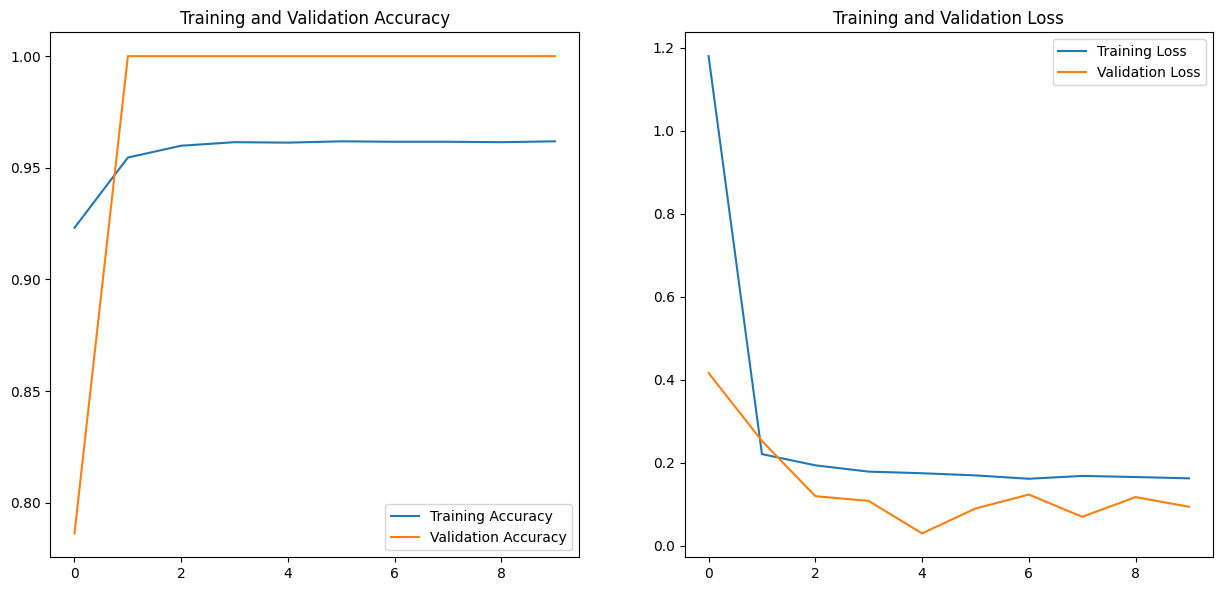

[[0.         0.85106383]
 [0.         0.14893617]]


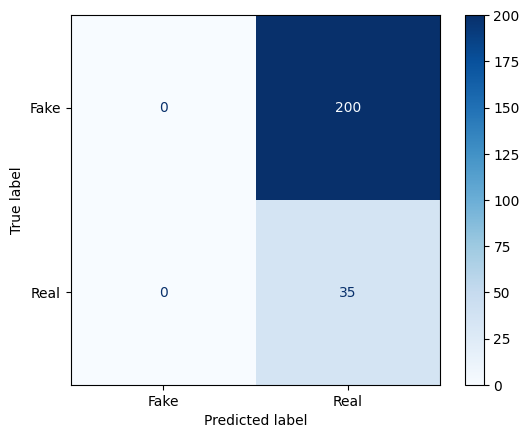

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # checkpoint_filepath = "/tmp/checkpoint"
    # checkpoint_callback = keras.callbacks.ModelCheckpoint(
    #     checkpoint_filepath,
    #     monitor="val_accuracy",
    #     save_best_only=True,
    #     save_weights_only=True,
    # )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
    )
    predictions = np.argmax(model.predict(X_test), axis=-1)

# Regain the original shape to evaluate predictions
    predictions = predictions.reshape(1, -1)[0]

    # Let’s also print the classification report to get more detailed results. (save it to pickel , early stopping)
    print(classification_report(y_test, predictions, target_names=['Healthy(class 0)', 'UnHealthy(class 1)']))
    print("Accuracy: ", metrics.accuracy_score(y_test, predictions) * 100)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # should be 5 for now should be 50
    epochs_range = range(10)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    #building the confusion matrix
    result = confusion_matrix(y_test, predictions , normalize='pred')
    print(result)
    labels = ["Fake", "Real"]
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

**Efficient Net Implementation** 

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB7(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


base_model.trainable = False

# keras tuner to find the best architecture

model = tf.keras.Sequential([base_model, tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(2, activation='softmax')])

model.compile(optimizer=keras.optimizers.Adam(0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# callback for early stopping
# patience is the number of epochs wth no improvement after which the training will be stopped
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

Epoch 1/3
177/177 [==============================] - 3185s 18s/step - loss: 0.1604 - accuracy: 0.9650 - val_loss: 3.0631 - val_accuracy: 0.1489
Epoch 2/3
177/177 [==============================] - 3175s 18s/step - loss: 0.1300 - accuracy: 0.9657 - val_loss: 2.5160 - val_accuracy: 0.1489
Epoch 3/3
177/177 [==============================] - 3198s 18s/step - loss: 0.1226 - accuracy: 0.9655 - val_loss: 2.4401 - val_accuracy: 0.1532


Efficient Net Results

8/8 [==============================] - 133s 16s/step


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



               precision    recall  f1-score   support

real(class 0)       1.00      0.01      0.01       200
fake(class 1)       0.15      1.00      0.26        35

     accuracy                           0.15       235
    macro avg       0.57      0.50      0.14       235
 weighted avg       0.87      0.15      0.05       235

Accuracy:  15.319148936170212
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-7e1383648ccb>", line 20, in <cell line: 20>
    plt.plot(epochs_range, acc, label='Training Accuracy')
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py", line 2812, in plot
    return gca().plot(
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py", line 1688, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/usr/local/lib/python3.10/dist-packages

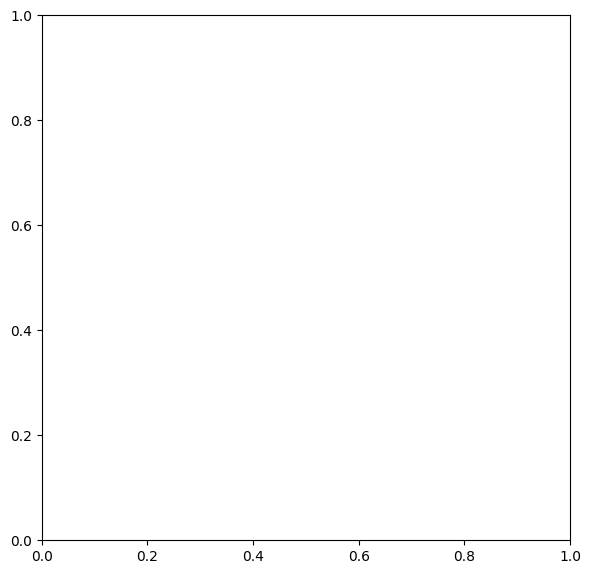

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

predictions = np.argmax(model.predict(X_test), axis=-1)
predictions = predictions.reshape(1, -1)[0]

    # Let’s also print the classification report to get more detailed results. (save it to pickel , early stopping)
print(classification_report(y_test, predictions, target_names=['real(class 0)', 'fake(class 1)']))
print("Accuracy: ", metrics.accuracy_score(y_test, predictions) * 100)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

    # should be 5 for now should be 50
epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()